# Internshala Data Science Challenege
Classification Problem

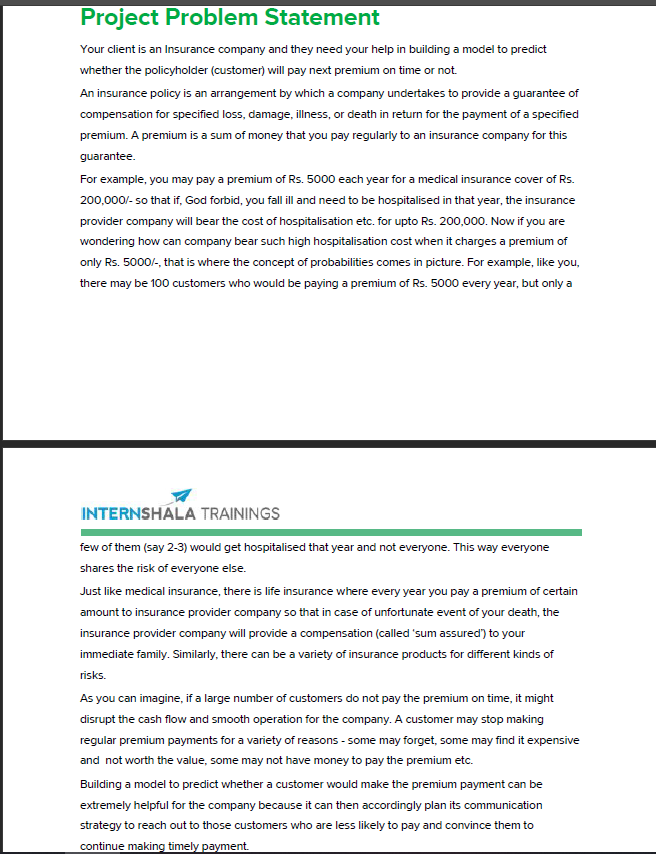

# Dataset Provided
A Training dataset of size 79853 rows × 12 columns
Test dataset of size 34224 rows × 11 columns

# Training Dataset _ columns
**id** : id of the customer

**ppaid** : percentage of premium paid by cash and credit 

**age** : Age of the customer in days format

**Income**	: Income of the customer

**late1**	: Number of premium late by 3-6 months

**late2**	: Number of premium late by 6-12 months

**late3**	: Number of premium late by more than 12 months

**uwscore**	: Underwriting Score

**nppaid**	: Number of premium paid on time

**channel**	: Channel through which customer is linked [A,B,C,D,E]

**residence_area_type**	: Urban or Rural

target : '0' if next premium will be late and '1' if next premium will be on time

# Test Dataset _ columns
Every column is same as Training column except for target column that we are going to predict


# Let's Start the show

Importing some Librariers that we need for performing computation

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np

Libraries for visualization of data

In [3]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs , init_notebook_mode , plot , iplot
import plotly.graph_objs as go
import plotly.express as px
init_notebook_mode(connected = True)

Libraries for Maachine Learning

In [4]:


# Scaling 
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
# Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
# Models that we will be using
import lightgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# For Scoring Results
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

# Importing Dataframe

In [17]:
data = pd.read_csv('/content/train_qnU1GcL.csv')

test = pd.read_csv(r"/content/test_rec.csv")

In [18]:
# creating a copy of original Dataset to limit our actions on duplicate  
df = data.copy()
tst = test.copy()

This is how the training data looks like

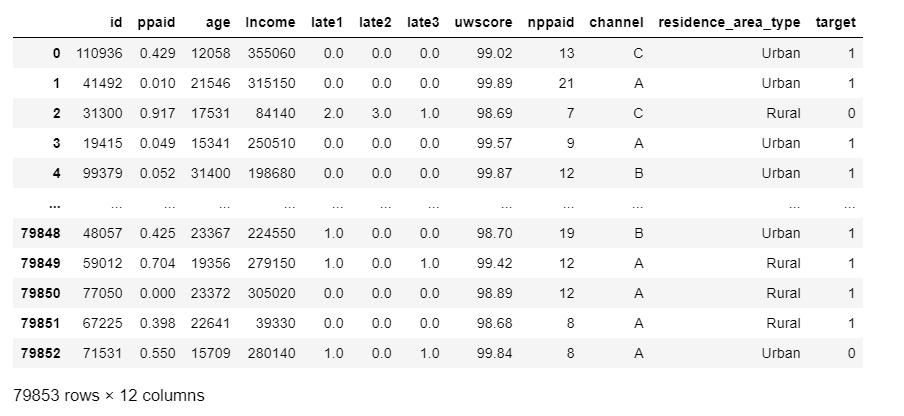

In [19]:
#For training Data we dont need id column so we can drop it
df = df.drop(['id'] , axis = 1)

Also it is better to have our age column in Years rather in days

In [20]:
df['age'] = df['age'].div(365)
tst['age'] = tst['age'].div(365)

Lets visualize all our columns to have a general view of data we have to wrangle

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15),)
plt.show()

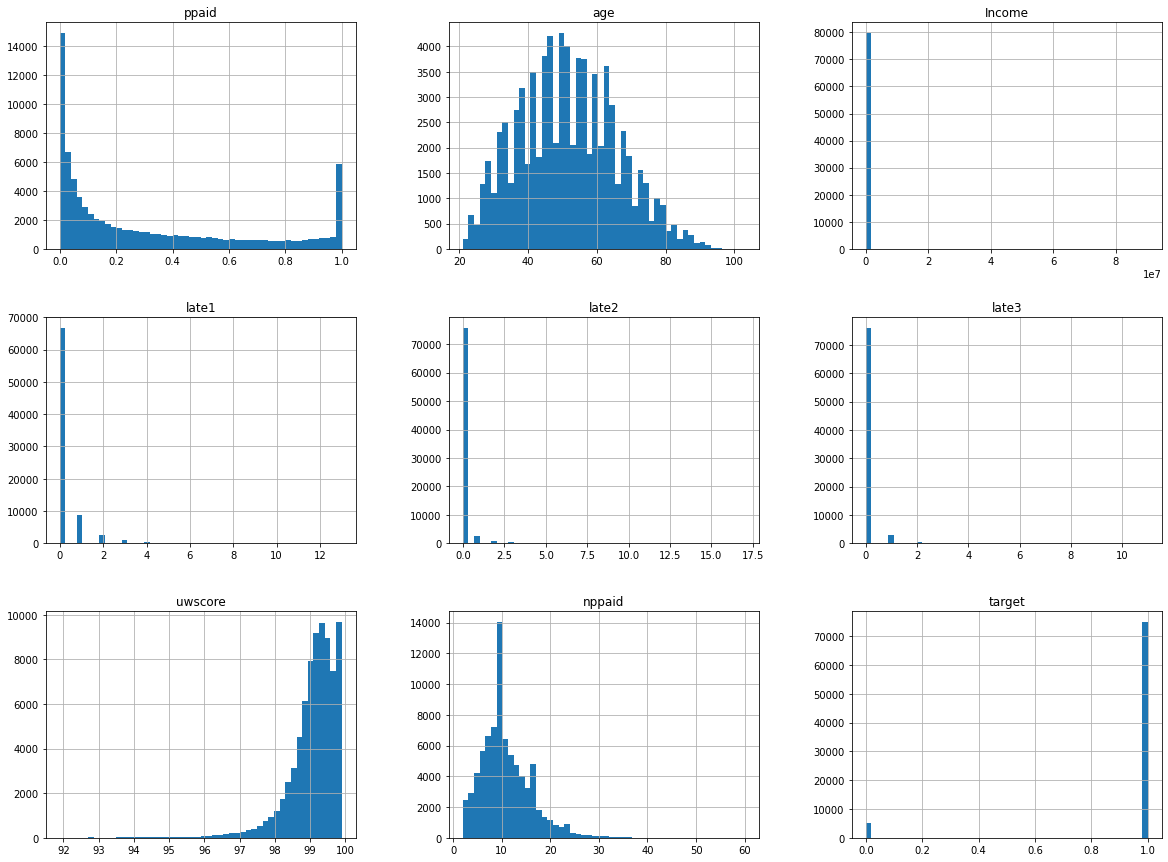

Insights from above plot are


1.   Income values have to be converted to Log transform as it is not visualize in this format
2.   Imbalance in data as Target plot have biased zeros and ones



# **Visualization and Data Wrangling**

In [21]:
df['Income'] = np.log(df['Income'])
tst['Income'] = np.log(tst['Income'])

In [ ]:
fig3 = px.histogram(df['Income'], nbins=200)
fig3.show()

After log normal transformation




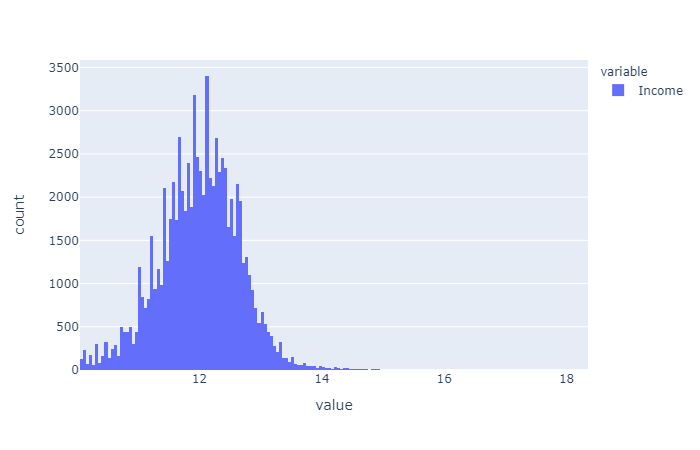

In [ ]:
# To check Data inbalance
sns.countplot(data['target'])

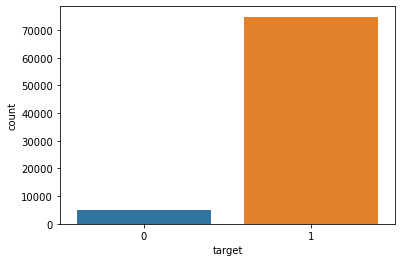

In Target column we have following bias:

1 :   74855

0  :   4998

**Finding Missing Values in our Dataset**

In [23]:
df.isnull().sum()

ppaid                  0
age                    0
Income                 0
late1                  0
late2                  0
late3                  0
uwscore                0
nppaid                 0
channel                0
residence_area_type    0
target                 0
dtype: int64

ppaid                     0

age                       0

Income                    0

late1                    97

late2                    97

late3                    97

uwscore                2974

nppaid                    0

channel                   0

residence_area_type       0

target                    0

We have missing values in late1,2,3 and uwscore columns

In [22]:
# Filling missing values with mean
df['uwscore'] = df['uwscore'].fillna(df['uwscore'].mean())
tst['uwscore'] = tst['uwscore'].fillna(tst['uwscore'].mean())

# Filling late 1, late2 and late3 by their mean value wiz in float but all values in these columns are in int therefore filling int part of the mean in all case
df['late1'] = df['late1'].fillna(int(df['late1'].mean()))
df['late2'] = df['late2'].fillna(int(df['late2'].mean()))
df['late3'] = df['late3'].fillna(int(df['late3'].mean()))
# Similarly for test dataset
tst['late1'] = tst['late1'].fillna(int(tst['late1'].mean()))
tst['late2'] = tst['late2'].fillna(int(tst['late2'].mean()))
tst['late3'] = tst['late3'].fillna(int(tst['late3'].mean()))




## **EDA**

Relation Between Variables using Pairplot

In [ ]:
sns.pairplot(df , hue = 'target')

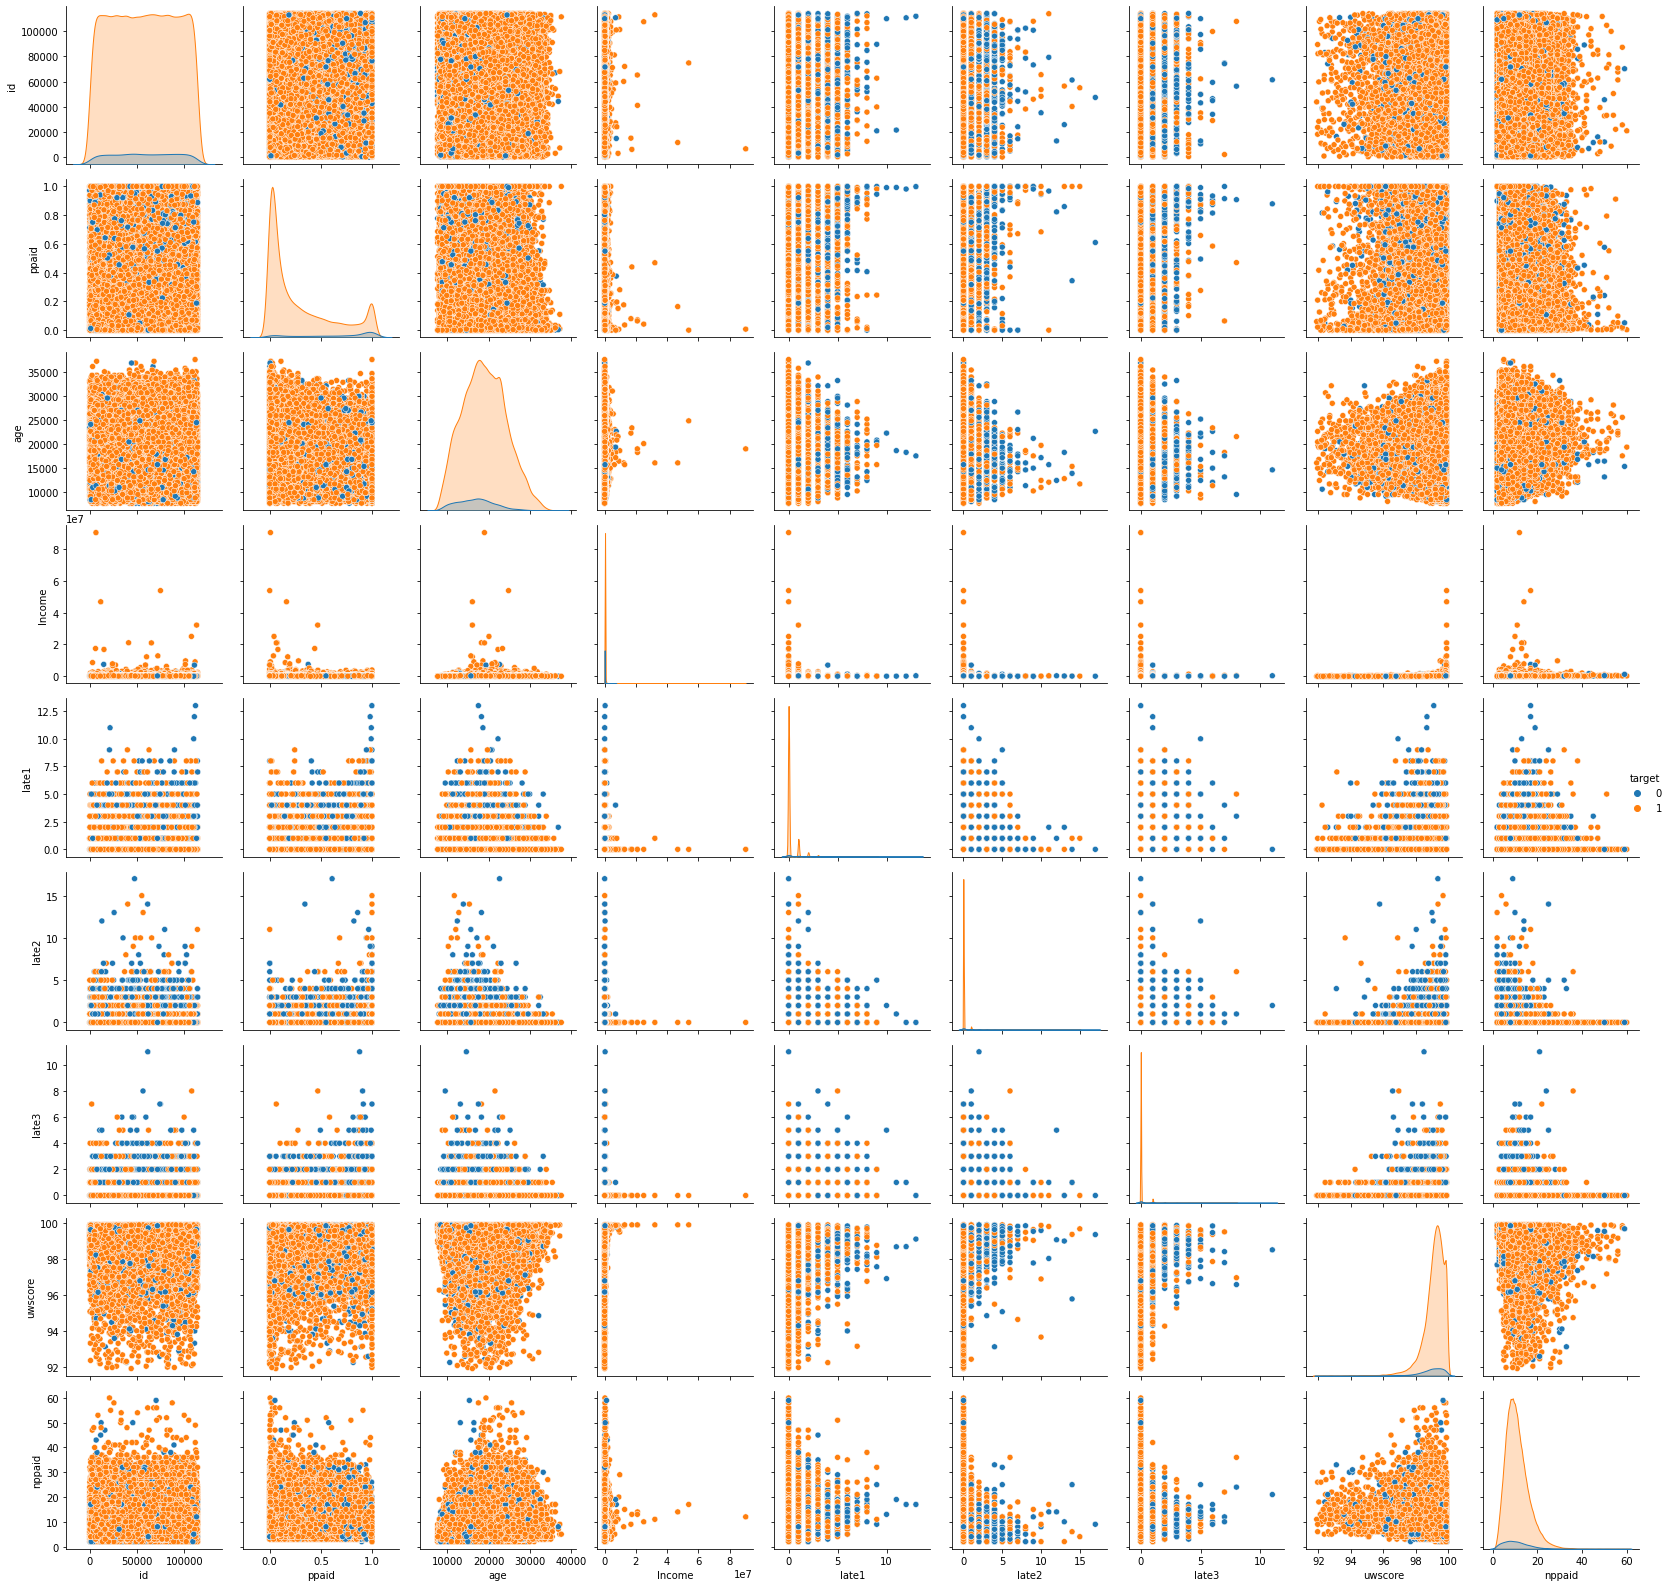

Relationship between Continues and categorical variables

In [ ]:
# Premium age , channel and target
figg = px.box(df,x = 'channel', y="age" , color = 'target')
figg.show()

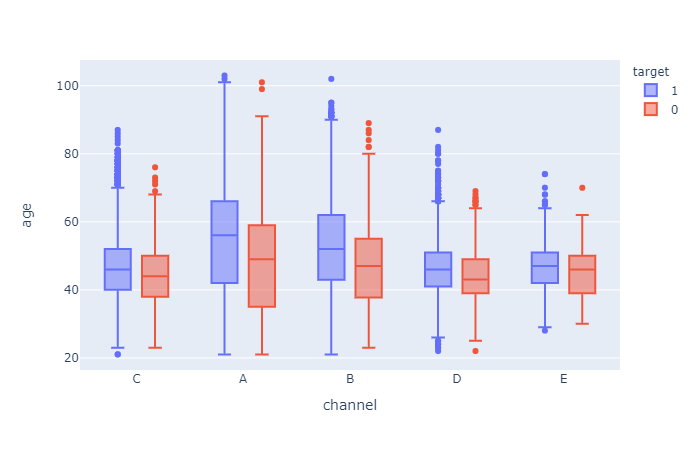

In [ ]:
#Premium paid by cash/creditcard , channel and target
figg = px.box(df,x = 'channel', y="ppaid" , color = 'target')
figg.show()

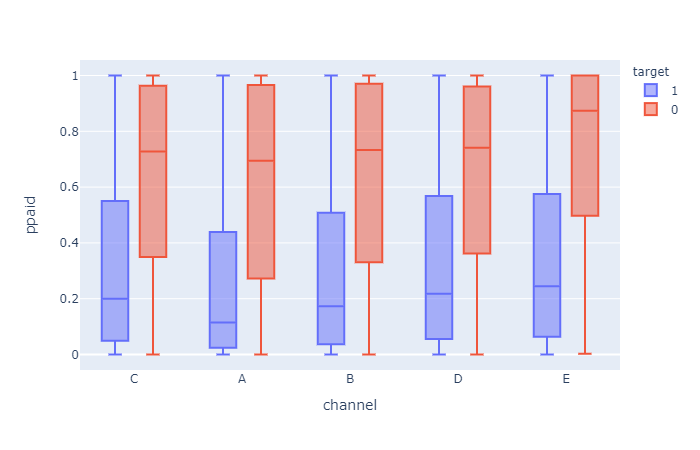

In [ ]:
# channel , Income and target as hue
figg = px.box(df,x = 'channel', y="Income" , color = 'target')
figg.show()

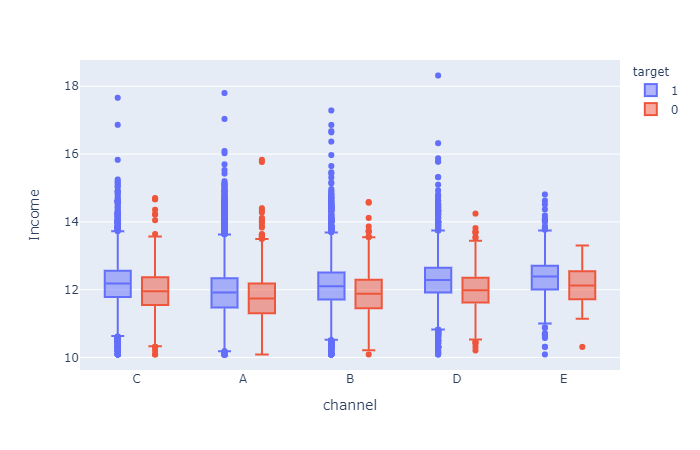

Above EDA results 

1.   There are many outliers in data therefore we need ROBUST Scaling to treat them while implementing our model
2.   Many of our features are good to go nad classifier can easily pick difference between variables



# **Feature Engineering**
Adding New Features in our Dataset


Number of Months late

avg of late months window * number of premiums late in that category

In [24]:

num_late_months = df.late1 * 4.5 + df.late2 * 9 + df.late3 * 12

df['late_months'] = num_late_months
num_late_months = tst.late1 * 4.5 + tst.late2 * 9 + tst.late3 * 12

tst['late_months'] = num_late_months


Income of customer and number of premium paid on that income ratio

In [25]:
In_npp = df['Income'].div(df['nppaid'])
df['In_npp'] = In_npp
In_npp = tst['Income'].div(tst['nppaid'])
tst['In_npp'] = In_npp


Under writing score is a function of type of past health condition of the customer and also Age 
Therefore what is the ratio of individuals UWSCORE and AGE is our new feature

In [26]:
uw_age = df['uwscore'].div(df['age'])
df['uw_age'] = uw_age
uw_age = tst['uwscore'].div(tst['age'])
tst['uw_age'] = uw_age

Total No. of premiums that one has to pay or will be paying in comming futer can be calculated as ppaid and nppaid are given

if a person pays a ratio of 0.5 as premium and he has paid 20 premiums on time then ppaid = nppaid / Total no. of Premiums  and therefore 

Total no. of Premiums = nppaid / ppaid (Integer)

But for 0 ppaid we can infer 0 no. of premiums

In [27]:
np_pp = []
for i in range(0 ,len(df.ppaid)):
    if df.iloc[i , 0] == 0:
        np_pp.append(0)
    else:
        l = int((df.iloc[i , 7])/(df.iloc[i,0]))
        np_pp.append(l)
        

In [28]:
df['np_pp'] = np_pp

In [29]:
np_pp = []
for i in range(0 ,len(tst.ppaid)):
    if tst.iloc[i , 0] == 0:
        np_pp.append(0)
    else:
        l =  int((tst.iloc[i , 7])/(tst.iloc[i,0]))
        np_pp.append(l)

In [30]:
tst['np_pp'] = np_pp

Income of and individual as per his Age

In [31]:
df['In_Age'] = df.Income.div(df.age)

In [32]:
tst['In_Age'] = tst.Income.div(tst.age)

Income and Total Late_months

In [33]:
df['In_late'] = df.late_months.div(df.Income)

In [34]:
tst['In_late'] = tst.late_months.div(tst.Income)

# MEAN ENCODING 

In [35]:
pd.crosstab(index = df['channel'] , columns =df['target'])

target,0,1
channel,,
A,2349,40785
B,1066,15446
C,903,11136
D,634,6925
E,46,563


In [36]:
means = df.groupby('channel').target.mean()

In [37]:
df['channel'+'mean_target'] = df['channel'].map(means)

In [38]:
tst['channel'+'mean_target'] = tst['channel'].map(means)

# Performing Robust Scaling

In [41]:
rob_scaler = RobustScaler()
minmax = MinMaxScaler()

In [42]:
# performing Robust Scaling on all features except late1 , 2 ,3 & late_months as these are int values instead we apply MinMax SScaler on them 
df['ppaid'] = rob_scaler.fit_transform(df['ppaid'].values.reshape(-1,1))
df['age'] = rob_scaler.fit_transform(df['age'].values.reshape(-1,1))
df['Income'] = rob_scaler.fit_transform(df['Income'].values.reshape(-1,1))
df['late1'] = minmax.fit_transform(df['late1'].values.reshape(-1,1))
df['late2'] = minmax.fit_transform(df['late2'].values.reshape(-1,1))
df['late3'] = minmax.fit_transform(df['late3'].values.reshape(-1,1))
df['uwscore'] = rob_scaler.fit_transform(df['uwscore'].values.reshape(-1,1))
df['nppaid'] = rob_scaler.fit_transform(df['nppaid'].values.reshape(-1,1))
df['late_months'] = minmax.fit_transform(df['late_months'].values.reshape(-1,1))
df['In_npp'] = rob_scaler.fit_transform(df['In_npp'].values.reshape(-1,1))
df['uw_age'] = rob_scaler.fit_transform(df['uw_age'].values.reshape(-1,1))
df['np_pp'] = rob_scaler.fit_transform(df['np_pp'].values.reshape(-1,1))
df['In_Age'] = rob_scaler.fit_transform(df['In_Age'].values.reshape(-1,1))
df['In_late'] = rob_scaler.fit_transform(df['In_late'].values.reshape(-1,1))

In [43]:
tst['ppaid'] = rob_scaler.fit_transform(tst['ppaid'].values.reshape(-1,1))
tst['age'] = rob_scaler.fit_transform(tst['age'].values.reshape(-1,1))
tst['Income'] = rob_scaler.fit_transform(tst['Income'].values.reshape(-1,1))
tst['late1'] = minmax.fit_transform(tst['late1'].values.reshape(-1,1))
tst['late2'] = minmax.fit_transform(tst['late2'].values.reshape(-1,1))
tst['late3'] = minmax.fit_transform(tst['late3'].values.reshape(-1,1))
tst['uwscore'] = rob_scaler.fit_transform(tst['uwscore'].values.reshape(-1,1))
tst['nppaid'] = rob_scaler.fit_transform(tst['nppaid'].values.reshape(-1,1))
tst['late_months'] = minmax.fit_transform(tst['late_months'].values.reshape(-1,1))
tst['In_npp'] = rob_scaler.fit_transform(tst['In_npp'].values.reshape(-1,1))
tst['uw_age'] = rob_scaler.fit_transform(tst['uw_age'].values.reshape(-1,1))
tst['np_pp'] = rob_scaler.fit_transform(tst['np_pp'].values.reshape(-1,1))
tst['In_Age'] = rob_scaler.fit_transform(tst['In_Age'].values.reshape(-1,1))
tst['In_late'] = rob_scaler.fit_transform(tst['In_late'].values.reshape(-1,1))

# performing test train splitting

In [44]:
X = df.drop('target', axis=1)
y = df['target']

**Here I have used Stratified splits as we have inbalanced target**
...

In [45]:
sss =  StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.33)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [ 8389  9987 48386 ... 12332 39728 52530] Test: [78182  6112 70456 ... 49700 76135 58708]
Train: [ 3415 40710 12054 ... 24462 25324  3917] Test: [ 7859 64501 34718 ... 42979  1613  5463]
Train: [59223  7280 55705 ...  3501 23372 26582] Test: [64055 75117 35259 ... 37227 29017 59883]
Train: [37132 43456  7469 ... 44166 31951 12313] Test: [ 5394 55508 73414 ... 77906 32877 11265]
Train: [ 7067 15115  7154 ... 79120 41254 24650] Test: [74275 51655 77707 ... 77619 57854 20680]


In [46]:
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.06259696 0.93740304]
[0.0625759 0.9374241]


Label Distributions: 



*   [0.06259696, 0.93740304] (training set 0,1 ratio)
*   [0.0625759, 0.9374241] (test set 0,1 ratio)



# Using Dummy Variables (One Hot Encode)

In [47]:
original_Xtrain = pd.get_dummies(original_Xtrain)
original_Xtest = pd.get_dummies(original_Xtest)

In [48]:
tst = pd.get_dummies(tst)

In [49]:
original_Xtrain.drop([ 'residence_area_type_Urban','channel_E' ], axis=1, inplace=True)
original_Xtest.drop([ 'residence_area_type_Urban','channel_E' ], axis=1, inplace=True)


In [50]:
tst.drop([ 'residence_area_type_Urban','channel_E'  ], axis=1, inplace=True)

# XGBOOST 

1.   Base Model 
2.   Hyper Parameter tunning using magical Grid Search CV



In [51]:
import xgboost as xgb
dtrain = xgb.DMatrix(original_Xtrain,label= original_ytrain)
dtest = xgb.DMatrix(original_Xtest, label= original_ytest)

In [52]:
params = {
    # Parameters that we are going to tune.
 'learning_rate' : 0.1,
 'n_estimators' : 1000,
 'max_depth' : 5,
 'min_child_weight' :1,
 'gamma' : 0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective' :'binary:logistic',
 'nthread' : 4,
 'scale_pos_weight' : 1,
 'seed': 27
}

In [53]:
params['eval_metric'] = "auc"

In [54]:
num_boost_round = 999

[0]	Test-auc:0.825664
Will train until Test-auc hasn't improved in 100 rounds.
[1]	Test-auc:0.826851
[2]	Test-auc:0.829056
[3]	Test-auc:0.836526
[4]	Test-auc:0.836665
[5]	Test-auc:0.836866
[6]	Test-auc:0.838107
[7]	Test-auc:0.838121
[8]	Test-auc:0.83916
[9]	Test-auc:0.839562
[10]	Test-auc:0.839451
[11]	Test-auc:0.839378
[12]	Test-auc:0.83978
[13]	Test-auc:0.839916
[14]	Test-auc:0.839963
[15]	Test-auc:0.840162
[16]	Test-auc:0.840492
[17]	Test-auc:0.840714
[18]	Test-auc:0.841726
[19]	Test-auc:0.842278
[20]	Test-auc:0.842464
[21]	Test-auc:0.842559
[22]	Test-auc:0.84259
[23]	Test-auc:0.84268
[24]	Test-auc:0.8427
[25]	Test-auc:0.842773
[26]	Test-auc:0.842958
[27]	Test-auc:0.843292
[28]	Test-auc:0.843349
[29]	Test-auc:0.843362
[30]	Test-auc:0.843315
[31]	Test-auc:0.843389
[32]	Test-auc:0.84365
[33]	Test-auc:0.843554
[34]	Test-auc:0.843442
[35]	Test-auc:0.843492
[36]	Test-auc:0.843592
[37]	Test-auc:0.843792
[38]	Test-auc:0.843861
[39]	Test-auc:0.843872
[40]	Test-auc:0.844094
[41]	Test-auc:0.8

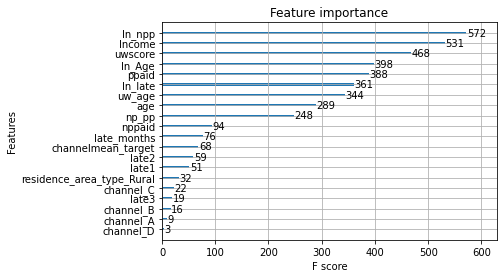

In [55]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=100
    
)
xgb.plot_importance(model)

With base model we get **Test_AUC score as 0.84467** which indicates our model is good and we can achieve better AUC score by tunning our base model.


**This AUC is achieved on 67 iteration this can be used as n_estimator values to tune our model further** 



**Feature Inportance**


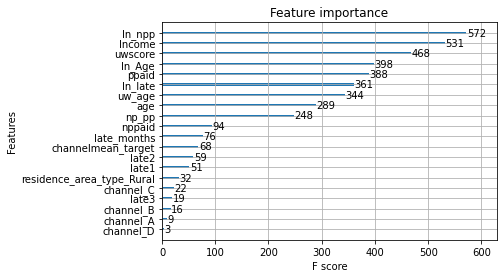

In [56]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=50
)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.825291,0.002418,0.817433,0.007399
1,0.834570,0.004226,0.824852,0.004670
2,0.839512,0.001462,0.828823,0.007550
3,0.840799,0.001424,0.830037,0.007265
4,0.841695,0.000881,0.830664,0.007389
5,0.843186,0.000998,0.831485,0.007554
6,0.844023,0.000935,0.832230,0.007420
7,0.845050,0.001448,0.833380,0.006841
8,0.845830,0.001409,0.834307,0.006726
9,0.847048,0.001353,0.835384,0.006351


In [57]:
cv_results['test-auc-mean'].max()

0.8411272000000001

We get test_auc_mean of 0.8411 

# Grid_Search CV for optimization of base model

In [59]:
params = {
  # Parameters that we are going to tune.
 'learning_rate' : 0.1,
 'n_estimators' : 67,
 'max_depth' : 5,
 'min_child_weight' :1,
 'gamma' : 0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective' :'binary:logistic',
 'nthread' : 4,
 'scale_pos_weight' : 1,
 'seed': 27
}

In [60]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=67, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(original_Xtrain, original_ytrain)
gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'max_depth': 3, 'min_child_weight': 1}, 0.8410850746268747)

from Above grid search we get ({'max_depth': 3, 'min_child_weight': 1}, 0.8410850746268747) this result

In [61]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=45, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(original_Xtrain, original_ytrain)
gsearch2.best_params_, gsearch2.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'max_depth': 4, 'min_child_weight': 2}, 0.8406446785382682)

In [65]:
param_test2b = {
 'min_child_weight':[2,3,4]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=67, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(original_Xtrain, original_ytrain)
gsearch2b.best_params_, gsearch2b.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'min_child_weight': 4}, 0.8413506733586468)

Tunnning GAMMA

In [66]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=67, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(original_Xtrain, original_ytrain)
gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'gamma': 0.0}, 0.8413506733586468)

In [67]:
params = {
    # Parameters that we are going to tune.
 'learning_rate' : 0.1,
 'n_estimators' : 1000,
 'max_depth' : 3,
 'eval_metric' : 'auc',
 'min_child_weight' :4,
 'gamma' : 0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective' :'binary:logistic',
 'nthread' : 4,
 'scale_pos_weight' : 1,
 'seed': 27
}

[0]	Test-auc:0.807977
Will train until Test-auc hasn't improved in 100 rounds.
[1]	Test-auc:0.812943
[2]	Test-auc:0.814485
[3]	Test-auc:0.815864
[4]	Test-auc:0.817065
[5]	Test-auc:0.826209
[6]	Test-auc:0.83045
[7]	Test-auc:0.830115
[8]	Test-auc:0.83027
[9]	Test-auc:0.831179
[10]	Test-auc:0.832183
[11]	Test-auc:0.831361
[12]	Test-auc:0.831651
[13]	Test-auc:0.831127
[14]	Test-auc:0.831888
[15]	Test-auc:0.833166
[16]	Test-auc:0.833717
[17]	Test-auc:0.833899
[18]	Test-auc:0.834122
[19]	Test-auc:0.83416
[20]	Test-auc:0.835271
[21]	Test-auc:0.836318
[22]	Test-auc:0.836397
[23]	Test-auc:0.836544
[24]	Test-auc:0.836776
[25]	Test-auc:0.837196
[26]	Test-auc:0.837945
[27]	Test-auc:0.83803
[28]	Test-auc:0.838533
[29]	Test-auc:0.838731
[30]	Test-auc:0.838883
[31]	Test-auc:0.838988
[32]	Test-auc:0.839973
[33]	Test-auc:0.840252
[34]	Test-auc:0.840717
[35]	Test-auc:0.840733
[36]	Test-auc:0.840806
[37]	Test-auc:0.840946
[38]	Test-auc:0.841512
[39]	Test-auc:0.841599
[40]	Test-auc:0.841825
[41]	Test-auc:

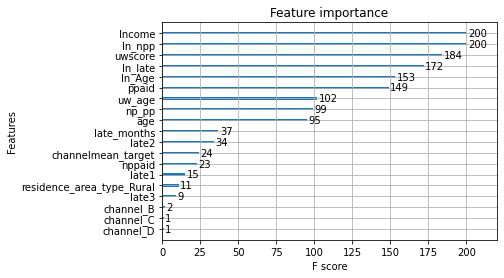

In [68]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=[(dtest, "Test")],
    early_stopping_rounds=100
    
)
xgb.plot_importance(model)

Tune subsample and colsample_bytree

In [69]:
param_test4 = {
 'subsample':[i/10.0 for i in range(2,10)],
 'colsample_bytree':[i/10.0 for i in range(2,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=67, max_depth=3,
 min_child_weight= 4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(original_Xtrain, original_ytrain)
gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8413506733586468)

In [70]:
param_test5 = {
 'subsample':[i/100.0 for i in range(70,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=67, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(original_Xtrain, original_ytrain)
gsearch5.best_params_, gsearch5.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8413506733586468)

 Tuning Regularization Parameters

In [71]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=67, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(original_Xtrain, original_ytrain)
gsearch6.best_params_, gsearch6.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'reg_alpha': 1e-05}, 0.8413506882393778)

In [73]:
# Better Performance (Best Model)
param_test7 = {
 'reg_alpha':[1e-06,(5 * 1e-06),1e-05,(5 * 1e-05),1e-04] # Furter comes out to be 0.01
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=67, max_depth=3,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(original_Xtrain, original_ytrain)
gsearch7.best_params_, gsearch7.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'reg_alpha': 4.9999999999999996e-06}, 0.8413506882393778)

In [84]:

params = {
 # Parameters that we are going to tune.
 'learning_rate' : 0.01,
 'n_estimators' : 1000,
 'max_depth' : 4,
 'eval_metric' : 'auc',
 'min_child_weight' :4,
 'gamma' : 0.2,
 'subsample':0.65,
 'colsample_bytree':0.85,
  'reg_alpha':0.01,
 'objective' :'binary:logistic',
 'nthread' : 4,
 'scale_pos_weight' : 1,
 'seed': 27
}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=4000,
    evals=[(dtest, "Test")],
    early_stopping_rounds=100
    
)
xgb.plot_importance(model)
xgb.plot_tree(model)

# LightGBM model

In [ ]:
import lightgbm



#categorical_features = ['channel','residence_area_type']

train_data = lightgbm.Dataset(original_Xtrain,label= original_ytrain)
test_data = lightgbm.Dataset(original_Xtest, label= original_ytest)


parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.001,
    'verbose': 0,
    'max_bin' : 300
    
}
evals_results = {}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       evals_result=evals_results,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

## Optimizing Light GBM by hyperparameter Tunning

In [ ]:
import lightgbm as lgb


In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}



# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval)

gridParams = {
    'learning_rate': [ 0.1],
    'num_leaves': [63],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary']
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

scoring = {'AUC': 'roc_auc'}

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, scoring=scoring, n_jobs=-1, refit='AUC')
# Run the grid
grid.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

In [ ]:
train_data = lightgbm.Dataset(original_Xtrain,label= original_ytrain)
test_data = lightgbm.Dataset(original_Xtest, label= original_ytest)

In [ ]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       evals_result=evals_results,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
gridParams1 = {
 'max_depth':range(1,20,2),
 'min_child_weight':range(1,20,2)
}

mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth= 5, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 5, min_child_samples=20, subsample=0.8, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid1 = GridSearchCV(mdl, gridParams1, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid1.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid1.best_params_)
print('Best score found by grid search is:', grid1.best_score_)


In [ ]:
gridParams2 = {
 'num_leaves':range(5,30,5),
 
}

mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth= 3, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 3, min_child_samples=20, subsample=0.8, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid3 = GridSearchCV(mdl, gridParams2, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid3.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid3.best_params_)
print('Best score found by grid search is:', grid3.best_score_)


In [ ]:
train_data = lightgbm.Dataset(original_Xtrain,label= original_ytrain)
test_data = lightgbm.Dataset(original_Xtest, label= original_ytest)


parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'max_depth' : 3 ,
    'min_child_weight': 3,
    'num_leaves': 10,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    #'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 0,
    
    
}
evals_results = {}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       evals_result=evals_results,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
gridParams3 = {
 'n_estimators':range(70,90,5),
 
}

mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth= 3, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 3, min_child_samples=20, subsample=0.8, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid4 = GridSearchCV(mdl, gridParams3, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid4.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid4.best_params_)
print('Best score found by grid search is:', grid4.best_score_)

In [ ]:
gridParams4 = {
 
 'subsample':[i/10.0 for i in range(2,10)],
 'colsample_bytree':[i/10.0 for i in range(2,10)]
}


mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth= 3, learning_rate=0.1, n_estimators=80, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 3, min_child_samples=20, subsample=0.8, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid5 = GridSearchCV(mdl, gridParams4, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid5.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid5.best_params_)
print('Best score found by grid search is:', grid5.best_score_)

In [ ]:
gridParams5 = {
 
 'subsample':[i/100.0 for i in range(15,30,5)],
 'colsample_bytree':[i/100.0 for i in range(80,95,5)]
}


mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth= 3, learning_rate=0.1, n_estimators=80, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 3, min_child_samples=20, subsample=0.8, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid6 = GridSearchCV(mdl, gridParams5, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid6.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid6.best_params_)
print('Best score found by grid search is:', grid6.best_score_)

In [ ]:
gridParams6 = {
 
 
 'max_bin': range(200,240,10)
}


mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth= 3,path_smooth = 3, learning_rate=0.1, n_estimators=80, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 3, min_child_samples=20, subsample=0.15, subsample_freq=0, colsample_bytree= 0.85, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid7 = GridSearchCV(mdl, gridParams6, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid7.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid7.best_params_)
print('Best score found by grid search is:', grid7.best_score_)

In [ ]:
gridParams6 = {
 
 
 'lambda_l1': [i/100.0 for i in range(30,50,5)],
 'lambda_l2' : [i/100.0 for i in range(50,70,5)],
 'min_gain_to_split': [i/100.0 for i in range(50,70,5)]
}


mdl = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth= 3,path_smooth = 3, learning_rate=0.1, n_estimators=80, subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, min_child_weight= 3, min_child_samples=20, subsample=0.15, subsample_freq=0, colsample_bytree= 0.85, reg_alpha=0.0, reg_lambda=0.0, random_state=1001, n_jobs= 4, silent=True, importance_type='split')
scoring = {'AUC': 'roc_auc'}

# Create the grid
grid7 = GridSearchCV(mdl, gridParams6, verbose=2, cv=5, scoring=scoring, n_jobs= 4, refit='AUC')
# Run the grid
grid7.fit(original_Xtrain, original_ytrain)
print('Best parameters found by grid search are:', grid7.best_params_)
print('Best score found by grid search is:', grid7.best_score_)

In [ ]:
train_data = lightgbm.Dataset(original_Xtrain,label= original_ytrain)
test_data = lightgbm.Dataset(original_Xtest, label= original_ytest)


parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'max_depth' : 3 ,
    'min_child_weight': 3,
    'num_leaves': 10,
    #'bagging_freq': 20,
    'learning_rate': 0.005,
    'verbose': 0,
    'n_estimator' : 80,
    'max_bin' : 220,
    'lambda_l1': 0.3, 'lambda_l2': 0.65, 'min_gain_to_split': 0.5,
    'subsample' : 0.15, 'colsample_bytree' : 0.85

    
    
}
evals_results = {}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       evals_result=evals_results,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(original_ytest, y_pred)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()